## **# 5 descriptions from testing data and generate 5 images with different noise z for each image respectively (25 images in total)**
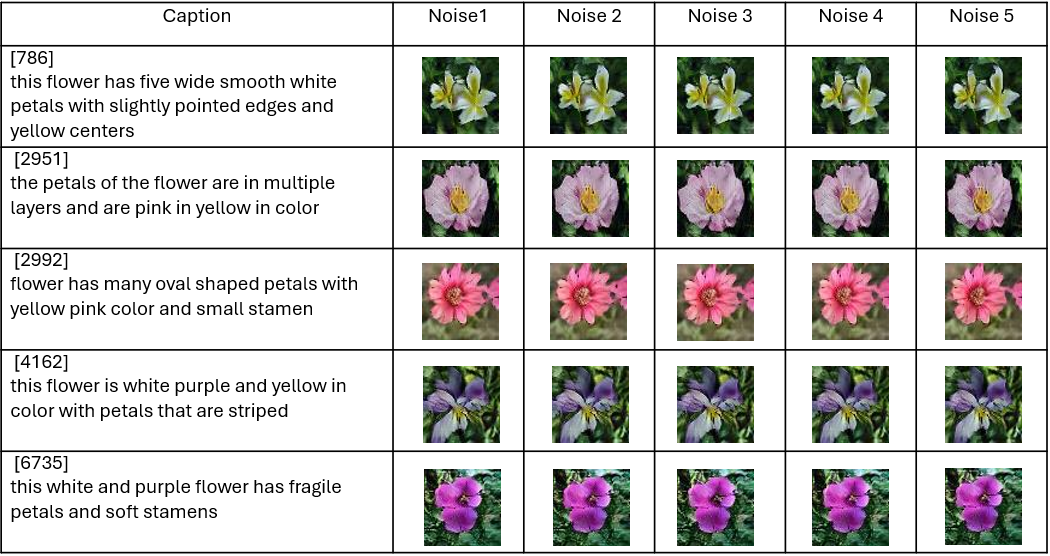

# **# About textencoder:**


---


We first try some pretrained textencoders like bert and find they cannot generate high quality images.

We suspect it is because that our task and data distribution are quite different from the origianl general purposes of this pretrained encoders.

We take bert as an example, it has more than 30000 tokens and with sentence max length up to 512 while our dataset contains only 5000 tokens with sentence max length only 20. And these sentences describing different flowers maybe hard to differentiate in the bert embedding area. So finally we decide to take the article "Learning Deep Representations of Fine-Grained Visual Descriptions" as inspiration and design our own textencoder.

We leverage the "asymmetric structured joint embedding" technique and it's related loss function mentioned in the article. We use pretrained Inception V3 model as our image embeddings and do max pooling to make the embedding size 512. And we replace the RCNN structure in the article with transformer because we think it could do better in features capturing.

The result is amazing, our textencoder can bring our score from 0.64 to 0.47 in 200 epochs.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Constants for image dimensions
IMAGE_HEIGHT = 299
IMAGE_WIDTH = 299
IMAGE_CHANNEL = 3
REPEAT_TIME = 1  # Adjust as needed

def training_data_generator(caption, image_path, label):
    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    caption = tf.cast(caption, tf.int32)
    label = tf.cast(label, tf.int32)

    return img, caption, label

def dataset_generator(df, batch_size, data_generator):
    # Prepare data grouped by label
    data_by_label = defaultdict(list)
    for idx, label in enumerate(df['labels'].values):
        data_by_label[label].append((df['Captions'].iloc[idx], df['ImagePath'].iloc[idx]))

    # Create a list of examples, one per label
    captions = []
    image_paths = []
    labels = []
    for i in range((MAX + MIN) // 2):
        sampled_captions = []
        sampled_image_paths = []
        sampled_labels = []
        for label, examples in data_by_label.items():
            # Randomly sample one example for this label
            sampled_caption, sampled_image_path = random.choice(examples)
            # Randomly select one caption if there are multiple
            if isinstance(sampled_caption, list):
                sampled_caption = random.choice(sampled_caption)

                # Insert '5429' at the beginning<CLS>
                sampled_caption.insert(0, '5429')
                # If '5427' exists, find its index and insert '5430' before it
                if '5427' in sampled_caption:
                    index_5427 = sampled_caption.index('5427')
                    sampled_caption.insert(index_5427, '5430')
                # If '5427' does not exist, insert '5430' at the end
                else:
                    sampled_caption.append('5430')

                # Replace '5427' with '0' for padding
                sampled_caption = ['0' if token == '5427' else token for token in sampled_caption]

            sampled_captions.append(sampled_caption)
            sampled_image_paths.append(sampled_image_path)
            sampled_labels.append(label)

        # Zip the lists together
        zipped_data = list(zip(sampled_captions, sampled_image_paths, sampled_labels))

        # Shuffle the zipped data
        random.shuffle(zipped_data)

        # Unpack the shuffled data
        sampled_captions, sampled_image_paths, sampled_labels = zip(*zipped_data)

        captions.extend(sampled_captions)
        image_paths.extend(sampled_image_paths)
        labels.extend(sampled_labels)

    # Pad captions to a uniform length
    captions = pad_sequences(captions, padding='post', value=0, dtype='int32', maxlen=SEQ_LEN)

    # Convert image paths and labels to NumPy arrays
    image_paths = np.asarray(image_paths)
    labels = np.asarray(labels, dtype=np.int32)

    # Create TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((captions, image_paths, labels))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat(REPEAT_TIME)  # Repeat the dataset
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
# Define positional encoding function
def positional_encoding(length, depth):
    depth = depth / 2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth   # (1, depth)

    angle_rates = 1 / (10000 ** depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1
    )

    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # Scale the embeddings by the square root of the model depth
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Add positional encoding to the embeddings
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x  # (batch_size, seq_length, d_model)

    def get_config(self):
        # Save the parameters needed to recreate the layer
        return {
            "vocab_size": self.vocab_size,
            "d_model": self.d_model
        }

    @classmethod
    def from_config(cls, config):
        # Create a new instance from the saved configuration
        return cls(**config)

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()
        self.mha_config = kwargs  # Store the MHA configuration for serialization

    def call(self, x, mask=None, training=False):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            attention_mask=mask,
            training=training  # Pass training to MHA if applicable
        )
        x = self.add([x, attn_output])
        x = self.layernorm(x, training=training)  # Pass training to LayerNormalization if applicable
        return x

    def get_config(self):
        config = super().get_config()  # Base layer configuration
        config.update(self.mha_config)  # Add MultiHeadAttention configuration
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.dff = dff
        self.dropout_rate = dropout_rate

        self.dense_1 = tf.keras.layers.Dense(dff, activation='relu')
        self.dense_2 = tf.keras.layers.Dense(d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x, training=False):
        # Process through the feed-forward network
        seq_output = self.dense_1(x)  # First dense layer
        seq_output = self.dense_2(seq_output)  # Second dense layer
        seq_output = self.dropout(seq_output, training=training)  # Apply dropout based on training

        # Add residual connection and apply normalization
        x = self.add([x, seq_output])
        x = self.layer_norm(x)
        return x

    def get_config(self):
        # Save the class configuration
        config = super().get_config()  # Base configuration
        config.update({
            "d_model": self.d_model,
            "dff": self.dff,
            "dropout_rate": self.dropout_rate
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create an instance from the saved configuration
        return cls(**config)

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.dropout_rate = dropout_rate

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate
        )
        self.ffn = FeedForward(d_model, dff, dropout_rate)

    def call(self, x, mask, training=False):
        # Apply self-attention with the training flag
        x = self.self_attention(x, mask=mask, training=training)

        # Apply the feed-forward network with the training flag
        x = self.ffn(x, training=training)

        return x  # (batch_size, seq_length, d_model)

    def get_config(self):
        # Save the class configuration
        config = super().get_config()  # Base configuration
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "dff": self.dff,
            "dropout_rate": self.dropout_rate
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Recreate the layer from its configuration
        return cls(**config)

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads,
                 dff, vocab_size, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)

        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.vocab_size = vocab_size
        self.dropout_rate = dropout_rate

        # Positional Embedding layer
        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        # Stack of Encoder layers
        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)
        ]

        # Dropout layer
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, seq_length, training=False):
        # Token embeddings with positional encoding
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`

        # Generate the attention mask
        mask = x._keras_mask  # Shape `(batch_size, seq_length)`
        reshaped_mask = tf.reshape(mask, (-1, seq_length, 1))  # `(batch_size, seq_length, 1)`
        reshaped_mask = tf.cast(reshaped_mask, tf.int32)
        result_mask = tf.matmul(reshaped_mask, tf.transpose(reshaped_mask, perm=[0, 2, 1]))
        result_mask = tf.cast(result_mask, tf.bool)

        # Apply dropout (respect the `training` flag)
        x = self.dropout(x, training=training)

        # Pass through the stack of Encoder layers
        for enc_layer in self.enc_layers:
            x = enc_layer(x, result_mask, training=training)

        # Extract the CLS token representation (first token)
        cls_token_output = x[:, 0, :]  # Shape `(batch_size, d_model)`

        return cls_token_output

    def get_config(self):
        # Save configuration for serialization
        config = super().get_config()
        config.update({
            "num_layers": self.num_layers,
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "dff": self.dff,
            "vocab_size": self.vocab_size,
            "dropout_rate": self.dropout_rate
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Recreate the Encoder from its config
        return cls(**config)

In [ ]:
def Fvt(x, y):
    """
    Compatibility metric.

    Arguments:
    * `x`, `y`: `tf.Tensor` where the last dimension sizes are equal.

    Returns:
    * Similarity metric between every pair of vectors.
    """
    # Perform matrix multiplication between x and the transposed y
    return tf.matmul(x, tf.transpose(y))#batchsize, batchsize

def modality_loss(comp):
    """
    Compute loss across modality (image or text).

    Arguments:
    * `comp`: Square `tf.Tensor` (can exclude batch dimension) containing compatibilities.
    * `dim`: `int`, dimension to check compatibility.
    * `batched`: `bool`, indicating if the first dimension is a batch dimension.

    Returns:
    * `tf.Tensor` of loss values.
    """

    # Create identity matrix and subtract from 1 to get Dy
    Dy = 1 - tf.eye(comp.shape[1], dtype=comp.dtype)

    # Calculate diagonal of `comp` and unsqueeze along the required dimension
    diag = tf.linalg.diag_part(comp)

    # Reshape to (diag.shape(2,), 1) and tile along axis 1 to get (2, 2)=(diag.shape=BATCH_SIZE, BATCH_SIZE)
    diag = tf.tile(tf.reshape(diag, (-1, 1)), [1, BATCH_SIZE])

    # Compute compatibility difference
    comp_dif = comp - diag

    # Add Dy and apply ReLU activation
    loss = tf.nn.relu(Dy + comp_dif)

    # Compute mean along the last two dimensions
    return tf.reduce_mean(loss)

def joint_embedding_loss(im_enc, txt_enc):
    """
    Compute and return joint embedding loss as defined in:
    `Learning Deep Representations of Fine-Grained Visual Descriptions`.

    Arguments:
    * `im_enc`: `tf.Tensor` of vector representations of images.
    * `txt_enc`: `tf.Tensor` of vector representations of captions.
      Must have the same dimensionality as `im_enc`.
    * `_lbls`: Not used, included for compatibility with other such losses.
    * `batched`: `bool`, whether the first dimension is a batch dimension.

    Returns:
    * `tf.Tensor` of loss[es if `batched`].
    """
    assert im_enc.shape == txt_enc.shape, "Image and text embeddings must have the same shape."

    # Compute compatibility matrix
    comp = Fvt(im_enc, txt_enc)

    # Compute modality loss across both dimensions (0 and 1)
    loss = modality_loss(comp)

    return loss

# **#Introduce the programming running process and the model we use:**


---



## **#DCGAN(and demonstrate a program process):**


---



DCGAN is the first GAN variant we chose to implement. It has been recommended in many literatures because it has some significant advantages. First, DCGAN introduces a convolutional layer to replace the fully connected layer, which allows the model to better capture the spatial structure and local features of the image, thereby generating more realistic images. The design characteristics of the convolutional layer make the model more efficient when processing high-dimensional images, avoiding the problem of excessive parameters that may be caused by a fully connected layer.

In addition, DCGAN uses ReLU and Leaky ReLU in the selection of activation functions. Together with the convolution structure, it helps to reduce the vanishing gradient problem and makes the training of the generator and discriminator more stable. This stability also allows the model to converge faster and produce higher quality images.

# Dataset:


---


Use the augmented data set to be processed.

In [ ]:
df = pd.read_pickle('aug_dataset_finegrained.pkl')
#df = pd.read_pickle('./text2ImgData_text_version.pkl')
#for test only.....
# Use slicing to get the first `nrows` rows
#nrows = 64
#df = df.iloc[:nrows]
#for test only

num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))

There are 58960 image in training data


In [ ]:
df.head()

Captions  \
ID                                                        
6734  [[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...   
6736  [[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...   
6737  [[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...   
6738  [[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...   
6739  [[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...   

                                      ImagePath  labels  
ID                                                       
6734  ./aug_dataset_finegrained/image_06734.jpg       1  
6736  ./aug_dataset_finegrained/image_06736.jpg       1  
6737  ./aug_dataset_finegrained/image_06737.jpg       1  
6738  ./aug_dataset_finegrained/image_06738.jpg       1  
6739  ./aug_dataset_finegrained/image_06739.jpg       1

In [ ]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [ ]:
#add CLS token
word2Id_dict['<CLS>']='5429'
id2word_dict['5429']='<CLS>'
#add EOS token
word2Id_dict['<EOS>']='5430'
id2word_dict['5430']='<EOS>'

In [ ]:
print(len(word2Id_dict))
print(len(id2word_dict))

5430
5431


In [ ]:
id2word_dict['0']

'<PAD>'

[['9', '1', '5', '11', '2', '7', '42', '60', '3', '21', '86', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['4', '241', '521', '1', '5', '77', '283', '22', '141', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['8', '1', '7', '22', '2', '3', '111', '70', '74', '13', '879', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['4', '1', '5', '90', '11', '2', '7', '503', '42', '60', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['4', '1', '15', '22', '3', '71', '13', '18', '7', '2', '10', '6', '42', '27', '9', '174', '5427', '5427', '5427', '5427'], ['4', '1', '15', '22', '44', '3', '21', '13', '18', '3', '5', '2', '10', '6', '42', '27', '9', '60', '5427', '5427'], ['4', '1', '5', '25', '22', '2', '7', '141', '60', '3', '8', '25', '21', '3', '22', '86', '5427', '5427', '5427', '5427'], ['4', '1', '5', '25', '22', '2', '10', '626', '89', '8', '21', '101', '7', '3220', 

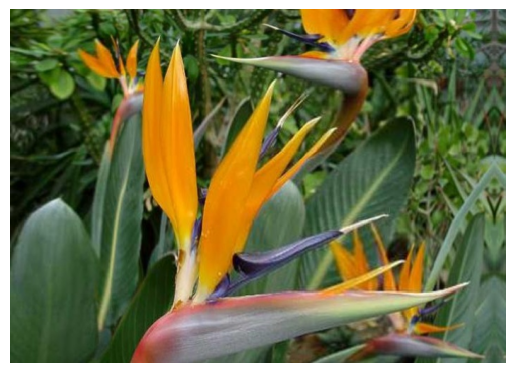

[['9', '1', '5', '11', '2', '7', '42', '60', '3', '21', '86', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['4', '241', '521', '1', '5', '77', '283', '22', '141', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['8', '1', '7', '22', '2', '3', '111', '70', '74', '13', '879', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['4', '1', '5', '90', '11', '2', '7', '503', '42', '60', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['4', '1', '15', '22', '3', '71', '13', '18', '7', '2', '10', '6', '42', '27', '9', '174', '5427', '5427', '5427', '5427'], ['4', '1', '15', '22', '44', '3', '21', '13', '18', '3', '5', '2', '10', '6', '42', '27', '9', '60', '5427', '5427'], ['4', '1', '5', '25', '22', '2', '7', '141', '60', '3', '8', '25', '21', '3', '22', '86', '5427', '5427', '5427', '5427'], ['4', '1', '5', '25', '22', '2', '10', '626', '89', '8', '21', '101', '7', '3220', 

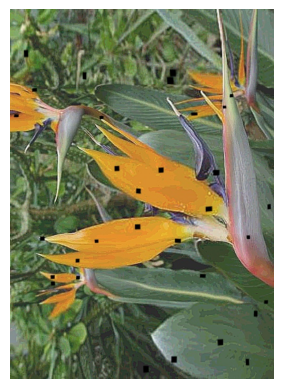

[['9', '1', '5', '11', '2', '7', '42', '60', '3', '21', '86', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['4', '241', '521', '1', '5', '77', '283', '22', '141', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['8', '1', '7', '22', '2', '3', '111', '70', '74', '13', '879', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['4', '1', '5', '90', '11', '2', '7', '503', '42', '60', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['4', '1', '15', '22', '3', '71', '13', '18', '7', '2', '10', '6', '42', '27', '9', '174', '5427', '5427', '5427', '5427'], ['4', '1', '15', '22', '44', '3', '21', '13', '18', '3', '5', '2', '10', '6', '42', '27', '9', '60', '5427', '5427'], ['4', '1', '5', '25', '22', '2', '7', '141', '60', '3', '8', '25', '21', '3', '22', '86', '5427', '5427', '5427', '5427'], ['4', '1', '5', '25', '22', '2', '10', '626', '89', '8', '21', '101', '7', '3220', 

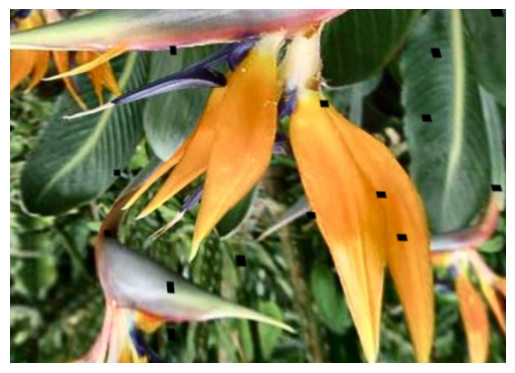

In [ ]:
import cv2
for i in range(10006,10009):
  idx = df.index[i]
  captions = df['Captions'][idx]
  image_path = df['ImagePath'][idx]
  image_path = image_path

  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  print(captions)

  # Step 3: Display the image using Matplotlib
  plt.imshow(image)
  plt.axis("off")  # Hide the axes for better visualization
  plt.show()

# Create Dataset by Dataset API：

---
The following code we implements is a data generator designed for training a deep learning model focused on image and caption matching. The `generate_image` function handles loading images from the given path, performing necessary transformations and normalization, scaling pixel values to the range [-1, 1], and resizing the images to the desired dimensions. The `training_data_generator` function pairs correct and incorrect images with their respective captions, ensuring that each caption is cast to an integer format.

The `dataset_generator` function is more complex. It loads image paths and captions from a DataFrame and randomly selects one caption for each image. The captions are preprocessed by inserting a specific token `5429` at the beginning, checking for the presence of token `5427`, and handling its position by inserting another token `5430` before it. If `5427` does not exist, `5430` is appended at the end. The token `5427` is then replaced with `0` for padding, and all captions are padded to a fixed length.

The function also creates mismatched pairs of images and captions by shuffling the data, generating incorrect captions and incorrect image paths. Finally, it constructs a `tf.data.Dataset` to handle data efficiently. This dataset supports operations like shuffling, repeating, batching, and prefetching, ensuring that the data is provided to the model in a controlled and efficient manner during training.


In [ ]:
MAX_SEQ_LENGTH=25

In [ ]:
REPEAT_TIME=3

In [ ]:
import random
import copy
from tensorflow.keras.preprocessing.sequence import pad_sequences
# in this competition, you have to generate image in size 64x64x3
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

In [ ]:
def generate_image(image_path):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = (img - 0.5) * 2 #[-1,1]
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    return img

def training_data_generator(caption, wrong_caption, image_path, wrong_image_path):
    img = generate_image(image_path)
    img_w = generate_image(wrong_image_path)

    caption = tf.cast(caption, tf.int32)
    caption_w = tf.cast(wrong_caption, tf.int32)

    return img, img_w, caption, caption_w

def dataset_generator(df, batch_size, data_generator):
    # load the training data into two NumPy arrays
    captions = df['Captions'].values
    caption = []
    # each image has 1 to 10 corresponding captions
    # we choose one of them randomly for training
    for i in range(len(captions)):
        sampled_caption = copy.deepcopy(random.choice(captions[i]))
        # Insert '5429' at the beginning<CLS>
        sampled_caption.insert(0, '5429')
        # If '5427' exists, find its index and insert '5430' before it
        if '5427' in sampled_caption:
            index_5427 = sampled_caption.index('5427')
            sampled_caption.insert(index_5427, '5430')
        # If '5427' does not exist, insert '5430' at the end
        else:
            sampled_caption.append('5430')

        # Replace '5427' with '0' for padding
        sampled_caption = ['0' if token == '5427' else token for token in sampled_caption]

        caption.append(sampled_caption)

    # Pad captions to a uniform length
    caption = pad_sequences(caption, padding='post', value=0, dtype='int32', maxlen=MAX_SEQ_LENGTH)

    image_path = df['ImagePath'].values

    wrong_caption = copy.deepcopy(caption)
    random.shuffle(wrong_caption)

    wrong_image_path = copy.deepcopy(image_path)
    random.shuffle(wrong_image_path)

    # assume that each row of `features` corresponds to the same row as `labels`.
    assert caption.shape[0] == image_path.shape[0]

    dataset = tf.data.Dataset.from_tensor_slices((caption, wrong_caption, image_path, wrong_image_path))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(caption))
    dataset = dataset.repeat(REPEAT_TIME)  # Repeat here
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
BATCH_SIZE = 64

In [ ]:
dataset = dataset_generator(df, BATCH_SIZE, training_data_generator)

In [ ]:
for img, img_w, caption, caption_w in dataset.take(1):
  print(caption.numpy()[:10])

  print(caption_w.numpy()[:10])


2024-12-13 05:37:51.672672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 7260 of 58960
2024-12-13 05:38:01.673141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 15945 of 58960
2024-12-13 05:38:21.672627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 31871 of 58960
2024-12-13 05:38:41.675944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 48969 of 58960
2024-12-13 05:38:52.992920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


[[5429    4    1   15   11    3   16   13   18    3    5    2   10    6
   100 5430    0    0    0    0    0    0    0    0    0]
 [5429    9    2   27    4    1    6   14    3  289  711  341    3    9
    33   15   21 5430    0    0    0    0    0    0    0]
 [5429    4    1    5    2   10    6   14    3    5   11   19 5430    0
     0    0    0    0    0    0    0    0    0    0    0]
 [5429    4    1    5   25   12    2    3    8  164   17   11   56   13
     9   76 5430    0    0    0    0    0    0    0    0]
 [5429    4  131    1    5    2   10    6   75    3   37    7   11 5430
     0    0    0    0    0    0    0    0    0    0    0]
 [5429    4    1    5    2   10    6   16    7   12   19 5430    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [5429    4    1    5    2   10    6   14    3   12    7   11   19 5430
     0    0    0    0    0    0    0    0    0    0    0]
 [5429    4    1    5    2   10    6   12    3    5   11   88 5430    0
     0    0    0  

## Textencoder:


---
Using our self-trained text encoder mentioned earlier.


In [ ]:
# Define positional encoding function
def positional_encoding(length, depth):
    depth = depth / 2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth   # (1, depth)

    angle_rates = 1 / (10000 ** depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1
    )

    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # Scale the embeddings by the square root of the model depth
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Add positional encoding to the embeddings
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x  # (batch_size, seq_length, d_model)

    def get_config(self):
        # Save the parameters needed to recreate the layer
        return {
            "vocab_size": self.vocab_size,
            "d_model": self.d_model
        }

    @classmethod
    def from_config(cls, config):
        # Create a new instance from the saved configuration
        return cls(**config)

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()
        self.mha_config = kwargs  # Store the MHA configuration for serialization

    def call(self, x, mask=None, training=False):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            attention_mask=mask,
            training=training  # Pass training to MHA if applicable
        )
        x = self.add([x, attn_output])
        x = self.layernorm(x, training=training)  # Pass training to LayerNormalization if applicable
        return x

    def get_config(self):
        config = super().get_config()  # Base layer configuration
        config.update(self.mha_config)  # Add MultiHeadAttention configuration
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x, mask=None, training=False):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            attention_mask=mask,
            training=training  # Pass training to MHA
        )
        x = self.add([x, attn_output])
        x = self.layernorm(x, training=training)  # Pass training to LayerNormalization if applicable
        return x  # (batch_size, seq_length, d_model)

    def get_config(self):
        # Retrieve the base configuration from BaseAttention
        base_config = super().get_config()
        return base_config

    @classmethod
    def from_config(cls, config):
        # Recreate GlobalSelfAttention using BaseAttention's logic
        return cls(**config)

In [ ]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.dff = dff
        self.dropout_rate = dropout_rate

        self.dense_1 = tf.keras.layers.Dense(dff, activation='relu')
        self.dense_2 = tf.keras.layers.Dense(d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x, training=False):
        # Process through the feed-forward network
        seq_output = self.dense_1(x)  # First dense layer
        seq_output = self.dense_2(seq_output)  # Second dense layer
        seq_output = self.dropout(seq_output, training=training)  # Apply dropout based on training

        # Add residual connection and apply normalization
        x = self.add([x, seq_output])
        x = self.layer_norm(x)
        return x

    def get_config(self):
        # Save the class configuration
        config = super().get_config()  # Base configuration
        config.update({
            "d_model": self.d_model,
            "dff": self.dff,
            "dropout_rate": self.dropout_rate
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create an instance from the saved configuration
        return cls(**config)

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.dropout_rate = dropout_rate

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate
        )
        self.ffn = FeedForward(d_model, dff, dropout_rate)

    def call(self, x, mask, training=False):
        # Apply self-attention with the training flag
        x = self.self_attention(x, mask=mask, training=training)

        # Apply the feed-forward network with the training flag
        x = self.ffn(x, training=training)

        return x  # (batch_size, seq_length, d_model)

    def get_config(self):
        # Save the class configuration
        config = super().get_config()  # Base configuration
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "dff": self.dff,
            "dropout_rate": self.dropout_rate
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Recreate the layer from its configuration
        return cls(**config)

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads,
                 dff, vocab_size, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)

        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.vocab_size = vocab_size
        self.dropout_rate = dropout_rate

        # Positional Embedding layer
        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        # Stack of Encoder layers
        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)
        ]

        # Dropout layer
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, seq_length, training=False):
        # Token embeddings with positional encoding
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`

        # Generate the attention mask
        mask = x._keras_mask  # Shape `(batch_size, seq_length)`
        reshaped_mask = tf.reshape(mask, (-1, seq_length, 1))  # `(batch_size, seq_length, 1)`
        reshaped_mask = tf.cast(reshaped_mask, tf.int32)
        result_mask = tf.matmul(reshaped_mask, tf.transpose(reshaped_mask, perm=[0, 2, 1]))
        result_mask = tf.cast(result_mask, tf.bool)

        # Apply dropout (respect the `training` flag)
        x = self.dropout(x, training=training)

        # Pass through the stack of Encoder layers
        for enc_layer in self.enc_layers:
            x = enc_layer(x, result_mask, training=training)

        # Extract the CLS token representation (first token)
        cls_token_output = x[:, 0, :]  # Shape `(batch_size, d_model)`

        return cls_token_output

    def get_config(self):
        # Save configuration for serialization
        config = super().get_config()
        config.update({
            "num_layers": self.num_layers,
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "dff": self.dff,
            "vocab_size": self.vocab_size,
            "dropout_rate": self.dropout_rate
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Recreate the Encoder from its config
        return cls(**config)

# Generator:


---
This code implements a generator model designed specifically to create images related to input text, incorporating both the characteristics of DCGAN and an innovative Gaussian noise mechanism. One of the key features is the custom Gaussian noise layer (`DecayingGaussianNoise`), which allows the standard deviation of the noise to decay progressively as training progresses. This design introduces more randomness during the early training stages to help the model explore potential data distributions, while reducing noise interference in later stages to focus on generating high-quality images.

The overall structure of the generator begins with text encoding, where the input text is flattened and noise is added. It then passes through a dense layer and batch normalization for further processing. The processed text features are concatenated with noise, forming the foundation for image generation. Subsequently, the model employs a dense layer to map the input to a base spatial resolution (e.g., 8x8x256), which is reshaped and fed into a series of transposed convolutional layers. Each of these layers progressively upsamples the image resolution. At multiple critical steps, the model applies the Gaussian noise layer in conjunction with batch normalization and LeakyReLU activation functions to ensure stability throughout the generation process.

The generator outputs the generated image through a transposed convolutional layer with a `tanh` activation function, constraining the range of the output to [-1, 1], which aligns with the normalization standard used in DCGAN. This design fully leverages the characteristics of DCGAN, such as multi-layer progressive upsampling in deep convolutional structures and adversarial learning during the generation process. Additionally, the introduction of Gaussian noise enhances the diversity of the generated images and helps the model better adapt to the challenges of adversarial training.


In [ ]:
class DecayingGaussianNoise(tf.keras.layers.Layer):
    """
    Custom Gaussian noise layer with decaying stddev.
    """
    def __init__(self, initial_stddev=0.1, decay_rate=0.55, **kwargs):
        super(DecayingGaussianNoise, self).__init__(**kwargs)
        self.initial_stddev = initial_stddev
        self.decay_rate = decay_rate
        self.current_stddev = initial_stddev  # Initialize the current stddev

    def call(self, inputs, training=False, epoch=0):
        if training:
            # Decay the stddev based on the current epoch
            self.current_stddev = self.initial_stddev / ((300 + epoch) ** self.decay_rate)
            noise = tf.random.normal(shape=tf.shape(inputs), stddev=self.current_stddev)
            return inputs + noise
        return inputs


class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z.
    Input: text and noise
    Output: fake image with size 64*64*3
    """
    def __init__(self, hparas, output_shape=(64, 64, 3)):
        super(Generator, self).__init__()

        self.hparas = hparas
        self.flatten = tf.keras.layers.Flatten()

        # Decaying Gaussian noise layer
        self.decaying_noise = DecayingGaussianNoise(initial_stddev=0.1, decay_rate=0.55)

        self.d1 = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.batch_norm_text = tf.keras.layers.BatchNormalization()

        # Calculate the base spatial size (8x8 for 64x64 output)
        self.base_size = (8, 8)
        self.output_channels = output_shape[-1]

        # Dense layer to project latent space to base resolution
        self.dense = tf.keras.layers.Dense(
            units=self.base_size[0] * self.base_size[1] * 256,
            use_bias=False,
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.leaky_relu1 = tf.keras.layers.LeakyReLU()

        # Reshape to base spatial resolution
        self.reshape = tf.keras.layers.Reshape((self.base_size[0], self.base_size[1], 256))

        # Upsampling layers
        self.conv2d_t1 = tf.keras.layers.Conv2DTranspose(
            filters=128,
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='same',
            use_bias=False,
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.leaky_relu2 = tf.keras.layers.LeakyReLU()

        self.conv2d_t2 = tf.keras.layers.Conv2DTranspose(
            filters=64,
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='same',
            use_bias=False,
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm3 = tf.keras.layers.BatchNormalization()
        self.leaky_relu3 = tf.keras.layers.LeakyReLU()

        self.conv2d_t3 = tf.keras.layers.Conv2DTranspose(
            filters=32,
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='same',
            use_bias=False,
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm4 = tf.keras.layers.BatchNormalization()
        self.leaky_relu4 = tf.keras.layers.LeakyReLU()

        # Final output layer
        self.output_layer = tf.keras.layers.Conv2DTranspose(
            filters=self.output_channels,
            kernel_size=(5, 5),
            strides=(1, 1),
            padding='same',
            activation='tanh',
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )

    def call(self, text, noise_z, epoch=0, training=True):
        """
        Forward pass for the generator.
        """
        # Pass through the text encoder
        text = self.flatten(text)
        text = self.decaying_noise(text, training=training, epoch=epoch)  # Add decaying Gaussian noise
        text = self.d1(text)
        text = self.batch_norm_text(text, training=training)
        text = tf.nn.leaky_relu(text)

        x = tf.concat([noise_z, text], axis=1)

        # Pass through the dense and reshape layers
        x = self.decaying_noise(x, training=training, epoch=epoch)  # Add decaying Gaussian noise
        x = self.dense(x)
        x = self.decaying_noise(x, training=training, epoch=epoch)  # Add decaying Gaussian noise
        x = self.batch_norm1(x, training=training)
        x = self.leaky_relu1(x)
        x = self.reshape(x)

        # Pass through upsampling layers
        x = self.conv2d_t1(x)
        x = self.decaying_noise(x, training=training, epoch=epoch)  # Add decaying Gaussian noise
        x = self.batch_norm2(x, training=training)
        x = self.leaky_relu2(x)

        x = self.conv2d_t2(x)
        x = self.decaying_noise(x, training=training, epoch=epoch)  # Add decaying Gaussian noise
        x = self.batch_norm3(x, training=training)
        x = self.leaky_relu3(x)

        x = self.conv2d_t3(x)
        x = self.decaying_noise(x, training=training, epoch=epoch)  # Add decaying Gaussian noise
        x = self.batch_norm4(x, training=training)
        x = self.leaky_relu4(x)

        # Final output layer
        x = self.output_layer(x)

        return x


# Discriminator:


---
This code implements a discriminator model for a conditional GAN, designed to distinguish real images from fake ones while ensuring alignment with text descriptions. It takes an image and a text feature as inputs.

The text is processed through a dense layer with LeakyReLU activation to extract features, while the image is passed through multiple convolutional layers with batch normalization, LeakyReLU, and dropout to extract hierarchical features. The processed text is reshaped and tiled to match the spatial dimensions of the image features. These are then concatenated along the channel dimension, fusing image and text information.

The combined features are processed through an additional convolutional layer, flattened, and passed to a dense layer to compute logits. A sigmoid activation produces a probability score, indicating whether the input is real or fake, while ensuring the image aligns with the text input. This design enforces realism and text consistency in the generated images.


In [ ]:
class Discriminator(tf.keras.Model):
    """
    Discriminator model to distinguish real images from fake ones.
    Input: Image of shape (64, 64, 3)
    Output: Probability (scalar) indicating whether the image is real or fake.
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()

        self.hparas = hparas
        self.flatten_text = tf.keras.layers.Flatten()
        self.d_text = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])

        # First Conv2D layer
        self.conv1 = layers.Conv2D(
            64, (5, 5), strides=(2, 2), padding='same',
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm1 = layers.BatchNormalization()
        self.leaky_relu1 = layers.LeakyReLU(alpha=0.2)
        self.dropout1 = layers.Dropout(0.3)

        # Second Conv2D layer
        self.conv2 = layers.Conv2D(
            128, (5, 5), strides=(2, 2), padding='same',
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm2 = layers.BatchNormalization()
        self.leaky_relu2 = layers.LeakyReLU(alpha=0.2)
        self.dropout2 = layers.Dropout(0.3)

        # Third Conv2D layer
        self.conv3 = layers.Conv2D(
            256, (5, 5), strides=(2, 2), padding='same',
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm3 = layers.BatchNormalization()
        self.leaky_relu3 = layers.LeakyReLU(alpha=0.2)
        self.dropout3 = layers.Dropout(0.3)

        # Fourth Conv2D layer
        self.conv4 = layers.Conv2D(
            512, (5, 5), strides=(2, 2), padding='same',
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm4 = layers.BatchNormalization()
        self.leaky_relu4 = layers.LeakyReLU(alpha=0.2)
        self.dropout4 = layers.Dropout(0.3)

        self.conv5 = layers.Conv2D(
            filters = 64*8, kernel_size = 1, strides = 1, padding = "same",
            kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev = 0.02))
        self.batch_norm5 = layers.BatchNormalization()
        self.leaky_relu5 = layers.LeakyReLU(alpha=0.2)

        # Flatten and output layer
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1)

    def call(self, img, text, training=True):
        """
        Forward pass through the discriminator model.
        Args:
            img: Input tensor (image batch).
            text: Text feature tensor.
            training: Boolean, specifies if the model is being trained or evaluated (for BatchNormalization).
        Returns:
            logits: Raw logits.
            output: Sigmoid-activated probability (scalar between 0 and 1).
        """
        # Process the text feature
        text = self.flatten_text(text)
        text = self.d_text(text)
        text = tf.nn.leaky_relu(text)

        # Process the image feature
        img = self.conv1(img)
        img = self.batch_norm1(img, training=training)
        img = self.leaky_relu1(img)
        img = self.dropout1(img, training=training)

        img = self.conv2(img)
        img = self.batch_norm2(img, training=training)
        img = self.leaky_relu2(img)
        img = self.dropout2(img, training=training)

        img = self.conv3(img)
        img = self.batch_norm3(img, training=training)
        img = self.leaky_relu3(img)
        img = self.dropout3(img, training=training)

        img = self.conv4(img)
        img = self.batch_norm4(img, training=training)
        img = self.leaky_relu4(img)
        img = self.dropout4(img, training=training)

        text = tf.reshape(text, [text.shape[0], 1, 1, text.shape[1]])#text shape(batch, embed)
        text = tf.tile(text, [1, img.shape[1], img.shape[2], 1])

        # Concatenate image and text features
        x = tf.concat([text, img], axis=-1)

        x = self.conv5(x)
        x = self.batch_norm5(x)
        x = self.leaky_relu5(x)

        x = self.flatten(x)

        logits = self.dense(x)
        output = tf.nn.sigmoid(logits)

        return logits, output

In [ ]:
EMBEDDING_DIM=512
NUM_HEADS=2
NUM_LAYERS=2
VOCAB_SIZE=len(id2word_dict)
DFF = 2048

In [ ]:
text_encoder = Encoder(num_layers=NUM_LAYERS,
                         d_model=EMBEDDING_DIM,
                         num_heads=NUM_HEADS,
                         dff=DFF,
                         vocab_size=VOCAB_SIZE)

In [ ]:
# Initialize the model by calling it with dummy input
dummy_input = tf.random.uniform((1, MAX_SEQ_LENGTH), maxval=VOCAB_SIZE, dtype=tf.int32)  # Batch size of 1, sequence length of 10
seq_length = tf.shape(dummy_input)[1]  # Infer sequence length from dummy input
_ = text_encoder(dummy_input, seq_length=MAX_SEQ_LENGTH, training=False)  # Call the model to initialize weights

# Load the saved weights
text_encoder.load_weights('encoder_weights.h5')

print("Weights successfully loaded!")

2024-12-17 09:53:46.723606: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Weights successfully loaded!


2024-12-17 09:53:46.971104: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


In [ ]:
hparas = {
    'MAX_SEQ_LENGTH': MAX_SEQ_LENGTH,                     # maximum sequence length
    'EMBED_DIM': EMBEDDING_DIM,                         # word embedding dimension
    'VOCAB_SIZE': len(id2word_dict),          # size of dictionary of captions
    'RNN_HIDDEN_SIZE': EMBEDDING_DIM,                   # number of RNN neurons
    'Z_DIM': 1024,                             # random noise z dimension
    'DENSE_DIM': EMBEDDING_DIM,                         # number of neurons in dense layer
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'BATCH_SIZE': 64,
    'LR': 1e-4,
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'N_EPOCH': 800,                            # number of epoch for demo
    'N_SAMPLE': num_training_sample*REPEAT_TIME,          # size of training data(repeat 10 times)
    'CHECKPOINTS_DIR': './checkpoints/demo2',  # checkpoint path
    'SAMPLE_DIR': 'samples/demo2',
    'PRINT_FREQ': 40                           # printing frequency of loss
}

In [ ]:
generator = Generator(hparas)
discriminator = Discriminator(hparas)

# Loss Function and Optimization:


---

For the discriminator loss, the function calculates the losses for different inputs: real images, fake images, class-wise real images (`real_logits_cw`), and instance-wise real images (`real_logits_iw`). Label smoothing is applied to make the model more robust, with real images given target labels randomly sampled between 0.9 and 1, while fake images and misaligned real images are assigned target labels between 0 and 0.1. These targets encourage the discriminator to correctly classify real images as real and penalize it for misclassifying fake or unrelated real images. The total loss is a combination of these individual losses, with class-wise and instance-wise losses weighted by a factor of 0.5.

For the generator loss, the function computes how well the generator fools the discriminator. It encourages the generator to produce images that the discriminator classifies as real by assigning a target of 1 to the discriminator's output for fake images.

Together, these loss functions guide the adversarial training process: the discriminator improves its ability to distinguish real from fake, while the generator enhances its capacity to create convincing fake images.


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_logits, fake_logits, real_logits_cw, real_logits_iw):
    # output value of real image should be 1
    #label smoothing here
    real_loss = cross_entropy(tf.random.uniform(real_logits.shape, minval=0.9, maxval=1), real_logits)
    # output value of fake image should be 0
    #label smoothing here
    fake_loss = cross_entropy(tf.random.uniform(fake_logits.shape, minval=0, maxval=0.1), fake_logits)

    real_cw_loss = cross_entropy(tf.random.uniform(real_logits_cw.shape, minval=0, maxval=0.1), real_logits_cw)

    real_iw_loss = cross_entropy(tf.random.uniform(real_logits_iw.shape, minval=0, maxval=0.1), real_logits_iw)

    total_loss = real_loss + 0.5* (fake_loss + real_cw_loss + real_iw_loss)
    return total_loss

def generator_loss(fake_output):
    # output value of fake image should be 0
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# we use seperated optimizers for training generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])
discriminator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])

In [ ]:
# one benefit of tf.train.Checkpoint() API is we can save everything seperately
checkpoint_dir = hparas['CHECKPOINTS_DIR']
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 text_encoder=text_encoder,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
@tf.function
def train_step(img, img_w, caption, caption_w, epoch):
    # random noise for generator
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Encode the text using the myencoder
        text_embed = text_encoder(caption, seq_length=MAX_SEQ_LENGTH, training=False)

        text_embed_w = text_encoder(caption_w, seq_length=MAX_SEQ_LENGTH, training=False)

        fake_image = generator(text=text_embed, noise_z=noise, epoch=epoch)

        real_logits, real_output = discriminator(img, text_embed)
        fake_logits, fake_output = discriminator(fake_image, text_embed)

        #img with caption_w
        real_logits_cw, real_output_cw = discriminator(img, text_embed_w)
        #img_w with caption
        real_logits_iw, real_output_iw = discriminator(img_w, text_embed)

        g_loss = generator_loss(fake_logits)
        d_loss = discriminator_loss(real_logits, fake_logits, real_logits_cw, real_logits_iw)

    grad_g = gen_tape.gradient(g_loss, generator.trainable_variables)
    grad_d = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(grad_g, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grad_d, discriminator.trainable_variables))

    return g_loss, d_loss

In [ ]:
@tf.function
def test_step(caption, noise):
    # Encode the text using the myencoder model
    text_embed = text_encoder(caption, seq_length=MAX_SEQ_LENGTH, training=False)

    fake_image = generator(text_embed, noise, training=False)
    return fake_image

# Visualiztion:


---
Add some data preprocessing step for self-define text-encoder.


In [ ]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    # getting the pixel values between [0, 1] to save it
    return plt.imsave(path, merge(images, size)*0.5 + 0.5)

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

In [ ]:
def sample_generator(caption, batch_size):
    caption = np.asarray(caption)
    caption = caption.astype(np.int32)
    dataset = tf.data.Dataset.from_tensor_slices(caption)
    dataset = dataset.batch(batch_size)
    return dataset

In [ ]:
def sent2IdList(line):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0

    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    tokens = prep_line.split(' ')
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]

    # Insert '5429' at the beginning<CLS>
    tokens.insert(0, '<CLS>')
    #insert <EOS>
    tokens.append('<EOS>')

    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l

    # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    line = [
        word2Id_dict[tokens[k]]
        if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
        for k in range(len(tokens))
    ]
    # Replace '5427' with '0' for padding
    line = ['0' if token == '5427' else token for token in line]

    return line

text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))

the flower shown has yellow anther red pistil and bright red petals.
['5429', '9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5430', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


In [ ]:
ni = int(np.ceil(np.sqrt(hparas['BATCH_SIZE'])))
sample_size = hparas['BATCH_SIZE']
sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
sample_sentence = ["the flower shown has yellow anther red pistil and bright red petals."] * int(sample_size/ni) + \
                  ["this flower has petals that are yellow, white and purple and has dark lines"] * int(sample_size/ni) + \
                  ["the petals on this flower are white with a yellow center"] * int(sample_size/ni) + \
                  ["this flower has a lot of small round pink petals."] * int(sample_size/ni) + \
                  ["this flower is orange in color, and has petals that are ruffled and rounded."] * int(sample_size/ni) + \
                  ["the flower has yellow petals and the center of it is brown."] * int(sample_size/ni) + \
                  ["this flower has petals that are blue and white."] * int(sample_size/ni) +\
                  ["these white flowers have petals that start off white in color and end in a white towards the tips."] * int(sample_size/ni)

In [ ]:
for i, sent in enumerate(sample_sentence):
    sample_sentence[i] = sent2IdList(sent)
    if i<20:
        print(sample_sentence[i])
sample_sentence = sample_generator(sample_sentence, hparas['BATCH_SIZE'])

['5429', '9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5430', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['5429', '9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5430', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['5429', '9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5430', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['5429', '9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5430', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['5429', '9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5430', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['5429', '9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5430', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['5429', '9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5430', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['5429', '9', '1', '82', '5

# Training

In [ ]:
if not os.path.exists(hparas['SAMPLE_DIR']):
    os.makedirs(hparas['SAMPLE_DIR'])

In [ ]:
def train(dataset, epochs):

    steps_per_epoch = int(hparas['N_SAMPLE']/hparas['BATCH_SIZE'])

    for epoch in range(hparas['N_EPOCH']):
        g_total_loss = 0
        d_total_loss = 0
        start = time.time()

        for img, img_w, caption, caption_w in dataset:
            g_loss, d_loss = train_step(img, img_w, caption, caption_w, epoch)
            g_total_loss += g_loss
            d_total_loss += d_loss

        time_tuple = time.localtime()
        time_string = time.strftime("%m/%d/%Y, %H:%M:%S", time_tuple)

        print("Epoch {}, gen_loss: {:.4f}, disc_loss: {:.4f}".format(epoch+1,
                                                                     g_total_loss/steps_per_epoch,
                                                                     d_total_loss/steps_per_epoch))
        print('Time for epoch {} is {:.4f} sec'.format(epoch+1, time.time()-start))

        # save the model
        if (epoch + 1) % hparas['PRINT_FREQ'] == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        # visualization
        if (epoch + 1) % hparas['PRINT_FREQ'] == 0:
            for caption in sample_sentence:
                fake_image = test_step(caption, sample_seed)
            save_images(fake_image, [ni, ni], hparas['SAMPLE_DIR']+'/train_{:02d}.jpg'.format(epoch))

        # Clear session to release memory and reset the computational graph
        tf.keras.backend.clear_session()

In [ ]:
checkpoint.restore(checkpoint_dir + '/ckpt-6').expect_partial()

In [ ]:
train(dataset, hparas['N_EPOCH'])

2024-12-17 09:55:12.486300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 12232 of 58960
2024-12-17 09:55:32.479634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 40248 of 58960
2024-12-17 09:55:42.486976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 54368 of 58960
2024-12-17 09:55:45.746165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-17 09:55:48.809894: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-12-17 09:55:49.172077: I exter

Epoch 1, gen_loss: 2.6517, disc_loss: 0.5683
Time for epoch 1 is 157.8272 sec


2024-12-17 09:57:50.325996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 12333 of 58960
2024-12-17 09:58:10.324508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 40515 of 58960
2024-12-17 09:58:20.326232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 54788 of 58960
2024-12-17 09:58:23.218320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-17 09:58:24.268497: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


# Evaluation

In [ ]:
def testing_data_generator(caption, index):
    caption = tf.cast(caption, tf.int32)
    return caption, index

def testing_dataset_generator(df, batch_size, data_generator):
    captions = data['Captions'].values
    caption = []
    for i in range(len(captions)):
        sampled_caption = copy.deepcopy(captions[i])

        # Insert '5429' at the beginning<CLS>
        sampled_caption.insert(0, '5429')
        # If '5427' exists, find its index and insert '5430' before it
        if '5427' in sampled_caption:
            index_5427 = sampled_caption.index('5427')
            sampled_caption.insert(index_5427, '5430')
        # If '5427' does not exist, insert '5430' at the end
        else:
            sampled_caption.append('5430')

        # Replace '5427' with '0' for padding
        sampled_caption = ['0' if token == '5427' else token for token in sampled_caption]

        caption.append(sampled_caption)


    # Pad captions to a uniform length
    caption = pad_sequences(caption, padding='post', value=0, dtype='int32', maxlen=MAX_SEQ_LENGTH)

    index = data['ID'].values
    index = np.asarray(index)

    dataset = tf.data.Dataset.from_tensor_slices((caption, index))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat().batch(batch_size)

    return dataset

In [ ]:
data = pd.read_pickle('./dataset/testData.pkl')

In [ ]:
data.head()

ID                                           Captions
0  6735  [4, 12, 3, 16, 1, 5, 791, 2, 3, 78, 59, 5427, ...
1  6740  [4, 1, 5, 158, 26, 64, 14, 2, 7, 12, 160, 3, 6...
2  6746  [8, 1, 7, 157, 12, 3, 14, 454, 2, 3, 11, 19, 5...
3  6759  [91, 1643, 31, 7, 2369, 2370, 3, 45, 59, 7, 56...
4  6762  [53, 6, 21, 13, 18, 2, 6, 34, 14, 13, 18, 5427...

In [ ]:
testing_dataset = testing_dataset_generator(data, hparas['BATCH_SIZE'], testing_data_generator)

In [ ]:
for caption, index in testing_dataset.take(1):
  print(caption.numpy()[:10])

[[5429    4   12    3   16    1    5  791    2    3   78   59 5430    0
     0    0    0    0    0    0    0    0    0    0    0]
 [5429    4    1    5  158   26   64   14    2    7   12  160    3  622
    46  282 5430    0    0    0    0    0    0    0    0]
 [5429    8    1    7  157   12    3   14  454    2    3   11   19 5430
     0    0    0    0    0    0    0    0    0    0    0]
 [5429   91 1643   31    7 2369 2370    3   45   59    7   56 5430    0
     0    0    0    0    0    0    0    0    0    0    0]
 [5429   53    6   21   13   18    2    6   34   14   13   18 5430    0
     0    0    0    0    0    0    0    0    0    0    0]
 [5429    4    1   15   29   14    7   93    2    3    8  578   21   31
  5430    0    0    0    0    0    0    0    0    0    0]
 [5429    4    1   15   12    3   11   13   18    7    2   10    6  123
    48 5430    0    0    0    0    0    0    0    0    0]
 [5429    4    1    5  600   53  161    6   16    3   11    7   88    3
    91   15  376  

In [ ]:
captions = data['Captions'].values

NUM_TEST = len(captions)
EPOCH_TEST = int(NUM_TEST / hparas['BATCH_SIZE'])

# Inferece

In [ ]:
INFERENCE_PATH = './inference/demo2'

In [ ]:
if not os.path.exists(INFERENCE_PATH):
    os.makedirs(INFERENCE_PATH)

In [ ]:
def inference(dataset):

    sample_size = hparas['BATCH_SIZE']
    sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)

    step = 0
    start = time.time()
    for captions, idx in dataset:
        if step > EPOCH_TEST:
            break

        fake_image = test_step(captions, sample_seed)
        step += 1
        for i in range(hparas['BATCH_SIZE']):
            plt.imsave(INFERENCE_PATH+'/inference_{:04d}.jpg'.format(idx[i]), fake_image[i].numpy()*0.5 + 0.5)

    print('Time for inference is {:.4f} sec'.format(time.time()-start))

In [ ]:
checkpoint.restore(checkpoint_dir + '/ckpt-6').expect_partial()

In [ ]:
inference(testing_dataset)

Time for inference is 0.4742 sec


# DCGAN result:


---
The result of REPEAT=2,EPOCHS=600,score=0.45

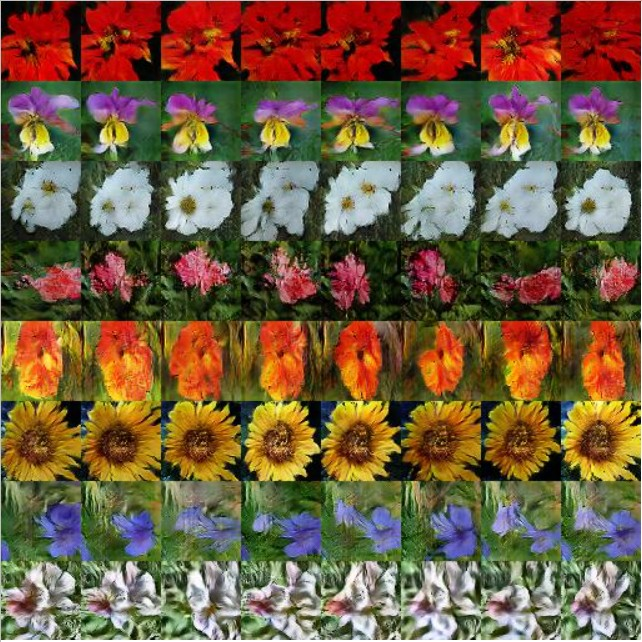

It can be seen that the generated images are of good quality and all correspond to text descriptions. However, the biggest problem is mode collapse. The model relies too much on specific features, and it is difficult to improve even if the noise intensity increases.




---



# **#DCGAN + DROPOUT:**


---

Due to the mode collapse problem, we add dropout to DCGAN to see whether it can reduce the effect of mode collapse.

In [ ]:
class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z.
    Input: text and noise
    Output: fake image with size 64*64*3
    """
    def __init__(self, hparas, output_shape=(64, 64, 3)):
        super(Generator, self).__init__()

        self.hparas = hparas
        self.flatten = tf.keras.layers.Flatten()

        # Decaying Gaussian noise layer
        self.decaying_noise = DecayingGaussianNoise(initial_stddev=0.1, decay_rate=0.55)

        self.d1 = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.batch_norm_text = tf.keras.layers.BatchNormalization()
        self.dropout_text = tf.keras.layers.Dropout(0.3)

        # Calculate the base spatial size (8x8 for 64x64 output)
        self.base_size = (8, 8)
        self.output_channels = output_shape[-1]

        # Dense layer to project latent space to base resolution
        self.dense = tf.keras.layers.Dense(
            units=self.base_size[0] * self.base_size[1] * 256,
            use_bias=False,
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.leaky_relu1 = tf.keras.layers.LeakyReLU()
        self.dropout1 = tf.keras.layers.Dropout(0.5)

        # Reshape to base spatial resolution
        self.reshape = tf.keras.layers.Reshape((self.base_size[0], self.base_size[1], 256))

        # Upsampling layers
        self.conv2d_t1 = tf.keras.layers.Conv2DTranspose(
            filters=128,
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='same',
            use_bias=False,
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.leaky_relu2 = tf.keras.layers.LeakyReLU()
        self.dropout2 = tf.keras.layers.Dropout(0.5)

        self.conv2d_t2 = tf.keras.layers.Conv2DTranspose(
            filters=64,
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='same',
            use_bias=False,
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm3 = tf.keras.layers.BatchNormalization()
        self.leaky_relu3 = tf.keras.layers.LeakyReLU()
        #self.dropout3 = tf.keras.layers.Dropout(0.5)

        self.conv2d_t3 = tf.keras.layers.Conv2DTranspose(
            filters=32,
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='same',
            use_bias=False,
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm4 = tf.keras.layers.BatchNormalization()
        self.leaky_relu4 = tf.keras.layers.LeakyReLU()
        #self.dropout4 = tf.keras.layers.Dropout(0.5)

        # Final output layer
        self.output_layer = tf.keras.layers.Conv2DTranspose(
            filters=self.output_channels,
            kernel_size=(5, 5),
            strides=(1, 1),
            padding='same',
            activation='tanh',
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )

    def call(self, text, noise_z, epoch=0, training=True):
        """
        Forward pass for the generator.
        """
        # Pass through the text encoder
        text = self.flatten(text)
        text = self.decaying_noise(text, training=training, epoch=epoch)  # Add decaying Gaussian noise
        text = self.d1(text)
        text = self.batch_norm_text(text, training=training)
        text = tf.nn.leaky_relu(text)
        text = self.dropout_text(text, training=True)

        x = tf.concat([noise_z, text], axis=1)

        # Pass through the dense and reshape layers
        x = self.decaying_noise(x, training=training, epoch=epoch)  # Add decaying Gaussian noise
        x = self.dense(x)
        x = self.decaying_noise(x, training=training, epoch=epoch)  # Add decaying Gaussian noise
        x = self.batch_norm1(x, training=training)
        x = self.leaky_relu1(x)
        x = self.dropout1(x, training=True)
        x = self.reshape(x)

        # Pass through upsampling layers
        x = self.conv2d_t1(x)
        x = self.decaying_noise(x, training=training, epoch=epoch)  # Add decaying Gaussian noise
        x = self.batch_norm2(x, training=training)
        x = self.leaky_relu2(x)
        x = self.dropout2(x, training=True)

        x = self.conv2d_t2(x)
        x = self.decaying_noise(x, training=training, epoch=epoch)  # Add decaying Gaussian noise
        x = self.batch_norm3(x, training=training)
        x = self.leaky_relu3(x)
        #x = self.dropout3(x, training=training)

        x = self.conv2d_t3(x)
        x = self.decaying_noise(x, training=training, epoch=epoch)  # Add decaying Gaussian noise
        x = self.batch_norm4(x, training=training)
        x = self.leaky_relu4(x)
        #x = self.dropout4(x, training=training)

        # Final output layer
        x = self.output_layer(x)

        return x

In [ ]:
class Discriminator(tf.keras.Model):
    """
    Discriminator model to distinguish real images from fake ones.
    Input: Image of shape (64, 64, 3)
    Output: Probability (scalar) indicating whether the image is real or fake.
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()

        self.hparas = hparas
        self.flatten_text = tf.keras.layers.Flatten()
        self.d_text = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])

        # First Conv2D layer
        self.conv1 = layers.Conv2D(
            64, (5, 5), strides=(2, 2), padding='same',
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm1 = layers.BatchNormalization()
        self.leaky_relu1 = layers.LeakyReLU(alpha=0.2)
        self.dropout1 = layers.Dropout(0.3)

        # Second Conv2D layer
        self.conv2 = layers.Conv2D(
            128, (5, 5), strides=(2, 2), padding='same',
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm2 = layers.BatchNormalization()
        self.leaky_relu2 = layers.LeakyReLU(alpha=0.2)
        self.dropout2 = layers.Dropout(0.3)

        # Third Conv2D layer
        self.conv3 = layers.Conv2D(
            256, (5, 5), strides=(2, 2), padding='same',
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm3 = layers.BatchNormalization()
        self.leaky_relu3 = layers.LeakyReLU(alpha=0.2)
        self.dropout3 = layers.Dropout(0.3)

        # Fourth Conv2D layer
        self.conv4 = layers.Conv2D(
            512, (5, 5), strides=(2, 2), padding='same',
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm4 = layers.BatchNormalization()
        self.leaky_relu4 = layers.LeakyReLU(alpha=0.2)
        self.dropout4 = layers.Dropout(0.3)

        self.conv5 = layers.Conv2D(
            filters = 64*8, kernel_size = 1, strides = 1, padding = "same",
            kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev = 0.02))
        self.batch_norm5 = layers.BatchNormalization()
        self.leaky_relu5 = layers.LeakyReLU(alpha=0.2)

        # Flatten and output layer
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1)

    def call(self, img, text, training=True):
        """
        Forward pass through the discriminator model.
        Args:
            img: Input tensor (image batch).
            text: Text feature tensor.
            training: Boolean, specifies if the model is being trained or evaluated (for BatchNormalization).
        Returns:
            logits: Raw logits.
            output: Sigmoid-activated probability (scalar between 0 and 1).
        """
        # Process the text feature
        text = self.flatten_text(text)
        text = self.d_text(text)
        text = tf.nn.leaky_relu(text)

        # Process the image feature
        img = self.conv1(img)
        img = self.batch_norm1(img, training=training)
        img = self.leaky_relu1(img)
        img = self.dropout1(img, training=training)

        img = self.conv2(img)
        img = self.batch_norm2(img, training=training)
        img = self.leaky_relu2(img)
        img = self.dropout2(img, training=training)

        img = self.conv3(img)
        img = self.batch_norm3(img, training=training)
        img = self.leaky_relu3(img)
        img = self.dropout3(img, training=training)

        img = self.conv4(img)
        img = self.batch_norm4(img, training=training)
        img = self.leaky_relu4(img)
        img = self.dropout4(img, training=training)

        text = tf.reshape(text, [text.shape[0], 1, 1, text.shape[1]])#text shape(batch, embed)
        text = tf.tile(text, [1, img.shape[1], img.shape[2], 1])

        # Concatenate image and text features
        x = tf.concat([text, img], axis=-1)

        x = self.conv5(x)
        x = self.batch_norm5(x)
        x = self.leaky_relu5(x)

        x = self.flatten(x)

        logits = self.dense(x)
        output = tf.nn.sigmoid(logits)

        return logits, output

# DCGAN + DROPOUT result:


---

The result of REPEAT=2,EPOCHS=600,score=0.46

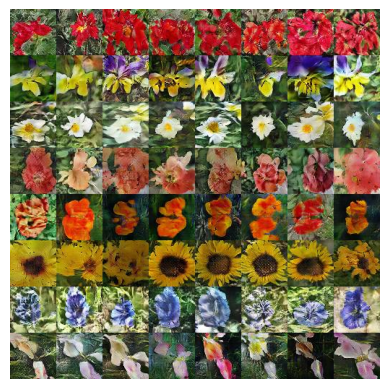

The generated images are indeed more variable, but the results on kaggle are poor (0.45->0.46)





---



# **#WGAN:**


---
We than try to use WGAN (Wasserstein GAN), which improves upon DCGAN by using the Wasserstein loss, which provides more stable training and avoids issues like vanishing gradients. Unlike DCGAN’s binary cross-entropy, WGAN’s loss offers smoother gradients, especially when the discriminator is too strong. WGANs also avoid the sigmoid activation in the discriminator, using a linear output instead, which gives more informative feedback to the generator. This leads to better convergence and reduces problems like mode collapse, making WGANs more stable and effective in many cases.



In [ ]:
class Discriminator(tf.keras.Model):
    """
    Discriminator model to distinguish real images from fake ones.
    Input: Image of shape (64, 64, 3)
    Output: Probability (scalar) indicating whether the image is real or fake.
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()

        self.hparas = hparas
        self.flatten_text = tf.keras.layers.Flatten()
        self.d_text = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])

        # First Conv2D layer
        self.conv1 = layers.Conv2D(
            64, (5, 5), strides=(2, 2), padding='same',
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        #self.batch_norm1 = layers.BatchNormalization()
        self.leaky_relu1 = layers.LeakyReLU(alpha=0.2)
        #self.dropout1 = layers.Dropout(0.3)

        # Second Conv2D layer
        self.conv2 = layers.Conv2D(
            128, (5, 5), strides=(2, 2), padding='same',
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        #self.batch_norm2 = layers.BatchNormalization()
        self.leaky_relu2 = layers.LeakyReLU(alpha=0.2)
        #self.dropout2 = layers.Dropout(0.3)

        # Third Conv2D layer
        self.conv3 = layers.Conv2D(
            256, (5, 5), strides=(2, 2), padding='same',
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        #self.batch_norm3 = layers.BatchNormalization()
        self.leaky_relu3 = layers.LeakyReLU(alpha=0.2)
        #self.dropout3 = layers.Dropout(0.3)

        # Fourth Conv2D layer
        self.conv4 = layers.Conv2D(
            512, (5, 5), strides=(2, 2), padding='same',
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        #self.batch_norm4 = layers.BatchNormalization()
        self.leaky_relu4 = layers.LeakyReLU(alpha=0.2)
        #self.dropout4 = layers.Dropout(0.3)

        self.conv5 = layers.Conv2D(
            filters = 64*8, kernel_size = 1, strides = 1, padding = "same",
            kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev = 0.02))
        #self.batch_norm5 = layers.BatchNormalization()
        self.leaky_relu5 = layers.LeakyReLU(alpha=0.2)

        # Flatten and output layer
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1)

    def call(self, img, text, training=True):
        """
        Forward pass through the discriminator model.
        Args:
            img: Input tensor (image batch).
            text: Text feature tensor.
            training: Boolean, specifies if the model is being trained or evaluated (for BatchNormalization).
        Returns:
            logits: Raw logits.
            output: Sigmoid-activated probability (scalar between 0 and 1).
        """
        # Process the text feature
        text = self.flatten_text(text)
        text = self.d_text(text)
        text = tf.nn.leaky_relu(text)

        # Process the image feature
        img = self.conv1(img)
        #img = self.batch_norm1(img, training=training)
        img = self.leaky_relu1(img)
        #img = self.dropout1(img, training=training)

        img = self.conv2(img)
        #img = self.batch_norm2(img, training=training)
        img = self.leaky_relu2(img)
        #img = self.dropout2(img, training=training)

        img = self.conv3(img)
        #img = self.batch_norm3(img, training=training)
        img = self.leaky_relu3(img)
        #img = self.dropout3(img, training=training)

        img = self.conv4(img)
        #img = self.batch_norm4(img, training=training)
        img = self.leaky_relu4(img)
        #img = self.dropout4(img, training=training)

        text = tf.reshape(text, [text.shape[0], 1, 1, text.shape[1]])#text shape(batch, embed)
        text = tf.tile(text, [1, img.shape[1], img.shape[2], 1])

        # Concatenate image and text features
        x = tf.concat([text, img], axis=-1)

        x = self.conv5(x)
        #x = self.batch_norm5(x)
        x = self.leaky_relu5(x)

        x = self.flatten(x)

        logits = self.dense(x)

        return logits

In [ ]:
@tf.function
def WGAN_GP_train_d_step(real_image, caption, epoch):
    '''
        One discriminator training step

        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''

    noise = tf.random.normal([hparas['BATCH_SIZE'], hparas['Z_DIM']])
    epsilon = tf.random.uniform(shape=[hparas['BATCH_SIZE'], 1, 1, 1], minval=0, maxval=1)
    ###################################
    # Train D
    ###################################
    with tf.GradientTape(persistent=True) as d_tape:
        with tf.GradientTape() as gp_tape:

            text_embed = text_encoder(caption, seq_length=MAX_SEQ_LENGTH, training=False)

            fake_image = generator(text=text_embed, noise_z=noise, epoch=epoch)

            fake_image_mixed = epsilon * tf.dtypes.cast(real_image, tf.float32) + ((1 - epsilon) * fake_image)

            fake_mixed_pred = discriminator(img=fake_image_mixed, text=text_embed)

        # Compute gradient penalty
        grads = gp_tape.gradient(fake_mixed_pred, fake_image_mixed)
        grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))

        real_pred = discriminator(img=real_image, text=text_embed)
        fake_pred = discriminator(img=fake_image, text=text_embed)

        discriminator_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + LAMBDA * gradient_penalty
    # Calculate the gradients for discriminator
    discriminator_gradients = d_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    # Apply the gradients to the optimizer
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return discriminator_loss

@tf.function
def WGAN_GP_train_g_step(real_image, caption, epoch):
    '''
        One generator training step

        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''

    noise = tf.random.normal([hparas['BATCH_SIZE'], hparas['Z_DIM']])
    ###################################
    # Train G
    ###################################
    with tf.GradientTape() as g_tape:

        text_embed = text_encoder(caption, seq_length=MAX_SEQ_LENGTH, training=False)

        fake_image = generator(text=text_embed, noise_z=noise, epoch=epoch)

        fake_pred = discriminator(fake_image, text_embed)

        generator_loss = -tf.reduce_mean(fake_pred)
    # Calculate the gradients for generator
    generator_gradients = g_tape.gradient(generator_loss, generator.trainable_variables)
    # Apply the gradients to the optimizer
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

    return generator_loss

# WGAN result:


---
The result of REPEAT=2,EPOCHS=1200,score=0.48

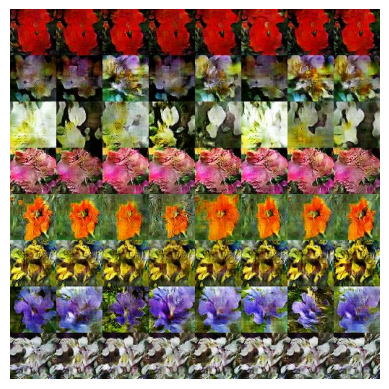

The problem we encountered is that wgan training is super slow. Even though the training ratio has been adjusted to 3:1, the original is train three times D and then one G. The ratio of trainG is much higher than the original version (the original is 5 or 10)), but There was still no time to complete the training before the deadline.





---



# **#Stack GAN:**


---
StackGAN offers several advantages over DCGAN and WGAN, particularly in terms of image quality and detail generation. Unlike DCGAN and WGAN, which generate images in a single step, StackGAN adopts a two-stage process. In the first stage, it generates low-resolution images, capturing basic structures. In the second stage, it refines these images to higher resolution, adding more intricate details. This hierarchical approach allows StackGAN to produce more realistic and detailed images, especially when dealing with high-resolution outputs.

We implemented the generator and discriminator of StackGAN, focusing solely on Stage 1. This is because, according to the model's architecture, Stage 1 alone is sufficient to generate 64×64 images. One of the key differences between StackGAN and DCGAN lies in how StackGAN uses a linear layer to compute the distribution of the text embedding, followed by sampling with a random value ϵ, which is then concatenated with noise to generate images. Using this approach along with our trained encoder, we achieved scores ranging from approximately 0.47 to 0.50.  
  
Due to time constraints, we did not implement StackGAN Stage 2, which involves taking the images generated in Stage 1 along with the text embedding to produce higher-resolution images (256×256). One potential modification would be to change the final output size to 64×64 and evaluate whether this approach yields better results compared to using only Stage 1.



In [ ]:
class StackGAN_Generator(tf.keras.Model):
    def __init__(self, hparas):
        super(StackGAN_Generator, self).__init__()
        self.hparas = hparas

        self.fc_layer = layers.Dense(hparas['EMBED_DIM']*2) # 128*2

        self.gf_dim = hparas['G_DIM']
        self.s16 = 4
        self.s8 = 8
        self.s4 = 16
        self.s2 = 32
        self.s = 64

        # Expanded fc_1_0_layers
        self.fc_dense = layers.Dense(self.s16 * self.s16 * self.gf_dim * 8)
        self.fc_batchnorm = layers.BatchNormalization()
        self.fc_reshape = layers.Reshape((self.s16, self.s16, self.gf_dim * 8))

        # Expanded conv1_1_layers
        self.conv1_1_conv1 = layers.Conv2D(self.gf_dim * 2, kernel_size=1, strides=1, padding='same')
        self.conv1_1_batchnorm1 = layers.BatchNormalization()
        self.conv1_1_leakyrelu1 = layers.LeakyReLU(alpha=0.2)

        self.conv1_1_conv2 = layers.Conv2D(self.gf_dim * 2, kernel_size=3, strides=1, padding='same')
        self.conv1_1_batchnorm2 = layers.BatchNormalization()
        self.conv1_1_leakyrelu2 = layers.LeakyReLU(alpha=0.2)

        self.conv1_1_conv3 = layers.Conv2D(self.gf_dim * 8, kernel_size=3, strides=1, padding='same')
        self.conv1_1_batchnorm3 = layers.BatchNormalization()

        # Expanded node2_0_layers
        self.node2_0_conv = layers.Conv2D(self.gf_dim * 4, kernel_size=3, strides=1, padding='same')
        self.node2_0_batchnorm = layers.BatchNormalization()

        # Expanded node2_1_layers
        self.node2_1_conv1 = layers.Conv2D(self.gf_dim * 1, kernel_size=1, strides=1, padding='same')
        self.node2_1_batchnorm1 = layers.BatchNormalization()
        self.node2_1_leakyrelu1 = layers.LeakyReLU(alpha=0.2)

        self.node2_1_conv2 = layers.Conv2D(self.gf_dim * 1, kernel_size=3, strides=1, padding='same')
        self.node2_1_batchnorm2 = layers.BatchNormalization()
        self.node2_1_leakyrelu2 = layers.LeakyReLU(alpha=0.2)

        self.node2_1_conv3 = layers.Conv2D(self.gf_dim * 4, kernel_size=3, strides=1, padding='same')
        self.node2_1_batchnorm3 = layers.BatchNormalization()

        # Expanded output_layers
        self.output_resize1 = layers.Lambda(lambda x: tf.image.resize(x, [self.s4, self.s4], method='nearest'))
        self.output_conv1 = layers.Conv2D(self.gf_dim * 2, kernel_size=3, strides=1, padding='same')
        self.output_batchnorm1 = layers.BatchNormalization()
        self.output_leakyrelu1 = layers.LeakyReLU(alpha=0.2)

        self.output_resize2 = layers.Lambda(lambda x: tf.image.resize(x, [self.s2, self.s2], method='nearest'))
        self.output_conv2 = layers.Conv2D(self.gf_dim, kernel_size=3, strides=1, padding='same')
        self.output_batchnorm2 = layers.BatchNormalization()
        self.output_leakyrelu2 = layers.LeakyReLU(alpha=0.2)

        self.output_resize3 = layers.Lambda(lambda x: tf.image.resize(x, [self.s, self.s], method='nearest'))
        self.output_conv3 = layers.Conv2D(3, kernel_size=3, strides=1, padding='same')
        self.output_activation = layers.Activation('tanh')

    def call(self, text_embedding, noise, training=True):
        conditions = self.fc_layer(text_embedding)
        conditions = layers.LeakyReLU(alpha=0.2)(conditions)
        mean = conditions[:, :self.hparas['EMBED_DIM']]
        log_sigma = conditions[:, self.hparas['EMBED_DIM']:]
        stddev = tf.exp(log_sigma)

        epsilon = tf.random.normal(tf.shape(stddev), mean=0.0, stddev=1.0)
        c = mean + stddev * epsilon
        combined_input = tf.concat([noise, c], axis=1)

        # fc_1_0_layers
        node1_0 = self.fc_dense(combined_input)
        node1_0 = self.fc_batchnorm(node1_0, training=training)
        node1_0 = self.fc_reshape(node1_0)

        # conv1_1_layers
        node1_1_conv1 = self.conv1_1_conv1(node1_0)
        node1_1_conv1 = self.conv1_1_batchnorm1(node1_1_conv1, training=training)
        node1_1_conv1 = self.conv1_1_leakyrelu1(node1_1_conv1)

        node1_1_conv2 = self.conv1_1_conv2(node1_1_conv1)
        node1_1_conv2 = self.conv1_1_batchnorm2(node1_1_conv2, training=training)
        node1_1_conv2 = self.conv1_1_leakyrelu2(node1_1_conv2)

        node1_1_conv3 = self.conv1_1_conv3(node1_1_conv2)
        node1_1_conv3 = self.conv1_1_batchnorm3(node1_1_conv3, training=training)

        node1 = tf.add(node1_0, node1_1_conv3)
        node1 = layers.LeakyReLU(alpha=0.2)(node1)

        # Node2
        node2_0 = tf.image.resize(node1, [self.s8, self.s8], method='nearest')
        node2_0_ = self.node2_0_conv(node2_0)
        node2_0_ = self.node2_0_batchnorm(node2_0_, training=training)

        node2_1_conv1 = self.node2_1_conv1(node2_0_)
        node2_1_conv1 = self.node2_1_batchnorm1(node2_1_conv1, training=training)
        node2_1_conv1 = self.node2_1_leakyrelu1(node2_1_conv1)

        node2_1_conv2 = self.node2_1_conv2(node2_1_conv1)
        node2_1_conv2 = self.node2_1_batchnorm2(node2_1_conv2, training=training)
        node2_1_conv2 = self.node2_1_leakyrelu2(node2_1_conv2)

        node2_1_conv3 = self.node2_1_conv3(node2_1_conv2)
        node2_1_conv3 = self.node2_1_batchnorm3(node2_1_conv3, training=training)

        node2 = tf.add(node2_0_, node2_1_conv3)
        node2 = layers.LeakyReLU(alpha=0.2)(node2)

        output = self.output_resize1(node2)
        output = self.output_conv1(output)
        output = self.output_batchnorm1(output, training=training)
        output = self.output_leakyrelu1(output)

        output = self.output_resize2(output)
        output = self.output_conv2(output)
        output = self.output_batchnorm2(output, training=training)
        output = self.output_leakyrelu2(output)

        output = self.output_resize3(output)
        output = self.output_conv3(output)
        output = self.output_activation(output)

        return output, mean, log_sigma

In [ ]:
class StackGAN_Discriminator(tf.keras.Model):
    def __init__(self, hparas):
        super(StackGAN_Discriminator, self).__init__()
        self.hparas = hparas
        self.df_dim = self.hparas['D_DIM']
        self.s16 = 4

        self.conv1_0_0 = layers.Conv2D(self.df_dim, (4, 4), strides=(2, 2), padding='same')
        self.conv1_0_1 = layers.Conv2D(self.df_dim * 2, (4, 4), strides=(2, 2), padding='same')
        self.bn1_0_1 = layers.BatchNormalization()
        self.conv1_0_2 = layers.Conv2D(self.df_dim * 4, (4, 4), strides=(2, 2), padding='same')
        self.bn1_0_2 = layers.BatchNormalization()
        self.conv1_0_3 = layers.Conv2D(self.df_dim * 8, (4, 4), strides=(2, 2), padding='same')
        self.bn1_0_3 = layers.BatchNormalization()

        self.conv1_1_0 = layers.Conv2D(self.df_dim * 2, (1, 1), strides=(1, 1), padding='same')
        self.bn1_1_0 = layers.BatchNormalization()
        self.conv1_1_1 = layers.Conv2D(self.df_dim * 2, (3, 3), strides=(1, 1), padding='same')
        self.bn1_1_1 = layers.BatchNormalization()
        self.conv1_1_2 = layers.Conv2D(self.df_dim * 8, (3, 3), strides=(1, 1), padding='same')
        self.bn1_1_2 = layers.BatchNormalization()

        self.fc_layer = layers.Dense(hparas['EMBED_DIM'])

        self.classifier_conv1 = layers.Conv2D(self.df_dim * 8, (1, 1), strides=(1, 1), padding='SAME')
        self.classifier_bn1 = layers.BatchNormalization()
        self.classifier_conv2 = layers.Conv2D(1, (self.s16, self.s16), strides=(self.s16, self.s16), padding='SAME')

    def call(self, image, text_embedding, training=True):
        x = self.conv1_0_0(image)
        x = layers.LeakyReLU(alpha=0.2)(x)

        x = self.conv1_0_1(x)
        x = self.bn1_0_1(x, training=training)
        x = layers.LeakyReLU(alpha=0.2)(x)

        x = self.conv1_0_2(x)
        x = self.bn1_0_2(x, training=training)

        node1_0 = self.conv1_0_3(x)
        node1_0 = self.bn1_0_3(node1_0, training=training)

        y = self.conv1_1_0(node1_0)
        y = self.bn1_1_0(y, training=training)
        y = layers.LeakyReLU(alpha=0.2)(y)

        y = self.conv1_1_1(y)
        y = self.bn1_1_1(y, training=training)
        y = layers.LeakyReLU(alpha=0.2)(y)

        node1_1 = self.conv1_1_2(y)
        node1_1 = self.bn1_1_2(node1_1, training=training)

        node1 = tf.add(node1_0, node1_1)
        node1 = layers.LeakyReLU(alpha=0.2)(node1)

        conditions = self.fc_layer(text_embedding)
        conditions = layers.LeakyReLU(alpha=0.2)(conditions)

        c_code = tf.expand_dims(tf.expand_dims(conditions, 1), 1)
        c_code = tf.tile(c_code, [1, 4, 4, 1])

        x_c_code = tf.concat([node1, c_code], axis=-1)

        x = self.classifier_conv1(x_c_code)
        x = self.classifier_bn1(x, training=training)
        x = layers.LeakyReLU(alpha=0.2)(x)

        logits = self.classifier_conv2(x)

        return logits

# Stack GAN result:


---
The result of REPEAT=,EPOCHS=600,score=0.48:

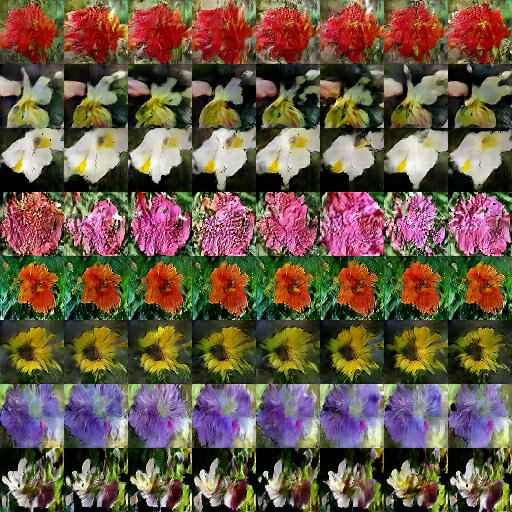

The result is that it can be seen that some samples are blurry and the details are not very good, and some captions do not match the pictures, such as the second row of samples, so the final overall score is about 0.47~0.50, which is not better than DCGAN.

The reason why the pictures trained by StackGAN may be blurrier than DCGAN may be related to its two-stage generation process. In StackGAN, lower resolution images are generated in the first stage, and then upsampled and detail enhanced in the second stage. Although such a process can produce higher-resolution images, during this process, the preliminary images generated at low resolution may affect the clarity of the final image, especially in the detail reconstruction part.


# **#Summary:**
In this competition, we tried to implement three GANs, namely DCGAN, WGAN and Stack GAN. Finally, we chose DCGAN as the result submission. However, this does not mean that the DCGAN model is stronger. On the contrary, more complex models need to be more nuanced. To achieve good results, we still have room for improvement in this part.

The biggest obstacle we encountered at first in the process was that pictures could not accurately represent text narratives, so the experts in the team trained a text encoder by themselves to replace the open source pre-trained model, which greatly improved the quality.

The biggest unsolved obstacle is still mode collapse. We have tried many methods such as label smoothing, adding noise and dropout, but none of them have obvious effects. WGAN is the most promising method but it has not been completed due to time factors.

This assignment was quite hard, but I gained a lot from it. I would like to thank my teammates again for their help.